# Image processing

Converting image to thumbnail, blur it, create a hash and then generate a base64 data uri.

In [13]:
import base64
import io
import os
from PIL import Image, ImageFilter
from datetime import datetime
from elasticsearch import Elasticsearch
import hashlib
import sys


In [2]:
IMAGE_DIR = r'./JPEGImages'
IMAGE_FORMAT = "webp"
ES_HOST = "http://localhost:9200"
ES_INDEX="images"
ES = Elasticsearch(ES_HOST)

In [3]:
def image_to_base64(img):
    buffer = io.BytesIO()
    img.save(buffer, format=IMAGE_FORMAT)
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

In [4]:
def generate_image_hash(image_data):
    sha256 = hashlib.sha256()
    data = image_data # io.BytesIO(image_data).read(32768)  # reduce RAM usage
    if not data:
        raise ValueError("No image data provided, hence no hash could be generated")
    sha256.update(data)

    return sha256.hexdigest()

In [22]:
def process_images(do_yield=True):
    processed_images = 0
    total_size = 0
    for file in os.listdir(IMAGE_DIR):
        # Limit to 1000 images
        if (processed_images == 1000):
             break
        with Image.open(f'{IMAGE_DIR}/{file}') as img:
            try:
                img.thumbnail((1000, 240)) # Set max height
                img_boxblur = img.filter(ImageFilter.BoxBlur(14))
                img_gaussblur = img_boxblur.filter(ImageFilter.GaussianBlur(12))
                original_image_hash = generate_image_hash(img.tobytes())
                image_hash = generate_image_hash(img_gaussblur.tobytes())
                # Show the original image and the blurred version
                # if processed_images % 100 == 0 and not processed_images == 0:
                #    img.show()
                #    img_gaussblur.show()
                img_b64  = f'data:image/{IMAGE_FORMAT};base64,{image_to_base64(img_gaussblur)}'
                total_size += len(img_b64)
                processed_images += 1
                if do_yield:
                    yield { "id": processed_images, "original_image_hash": original_image_hash, "image_hash": image_hash, "path": f"{IMAGE_DIR}/{file}", "data_uri": img_b64, "timestamp": datetime.now().timestamp(), "bytes": len(img_b64)}
            except OSError:
                print(f"Error: Could not process file {file}")
            except KeyboardInterrupt:
                print("Halting processing")
                break
    print(f"Processed {processed_images} files with total size of {total_size}.")

In [27]:
# Check
for obj in process_images():
  if (obj["id"] % 1000 == 0):
    print(obj)
#process_images(do_yield=False)

Halting processing
Processed 20 files with total size of 36536.


## Test with indexing images in elastic

Index base64 encoded images in Elastic.


In [74]:
def es_insert(doc):
  if ES.exists(index=ES_INDEX, id=doc["id"]):
    ES.update(index=ES_INDEX, id=doc["id"], doc=doc)
  else:
    ES.create(index=ES_INDEX, id=doc["id"], document=doc)

In [80]:
for obj in process_images():
  es_insert(obj)

Error: Could not process file 2009_001750.jpg
Processed 12096 files with total size of 22262240.


Check the size of the blurred base64 data uri in Elastic, would like to keep them as small as possible

In [81]:
ES.count(index=ES_INDEX, query={"range": { "bytes": {"gte": 3000}}})

ObjectApiResponse({'count': 95, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}})

ObjectApiResponse({'took': 5, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 1.0, 'hits': [{'_index': 'images', '_id': '1', '_score': 1.0, '_ignored': ['data_uri.keyword'], '_source': {'id': 1, 'path': './JPEGImages/2012_000760.jpg', 'data_uri': '', 'timestamp': 1671440452.688283, 'bytes': 2315, 'image_hash': 'c824f977e43ad28a9416bfb81881f8dc89a17a160ab382402e4ca93b801a5502', 'original_image_hash': 'b80d6b96fa77f7a9568e0ca0ac5abc84da735bad50ae01ac46cc05198a9e1730'}}, {'_index': 'images', '_id': '2', '_score': 1.0, '_ignored': ['data_uri.keyword'], '_source': {'id': 2, 'path': './JPEGImages/2009_002515.jpg', 'data_uri': '', 'timestamp': 1671440452.757077, 'bytes': 1803, 'image_hash': '7830a023b93893f6e51fd2c8a411bd617173dd03d5bc94173814eae804e7cf8b', 'original_image_hash': '243446a4ac401c63bf6e528e2b2e4e8cfe601a9e1dd1037db64ef73dc01ef371'}}, {'_index': 'images', '_id': '3', '_sc
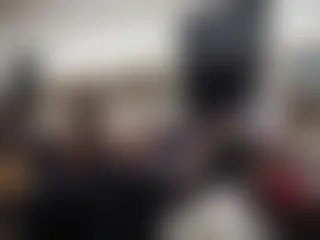
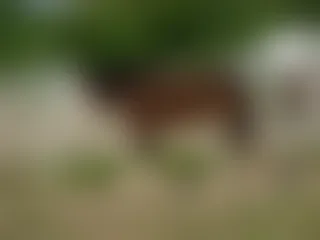
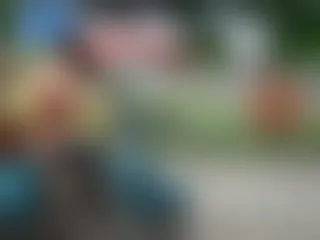
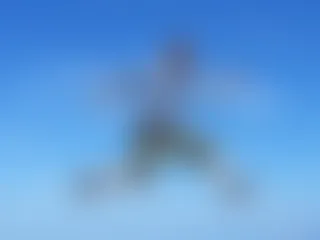
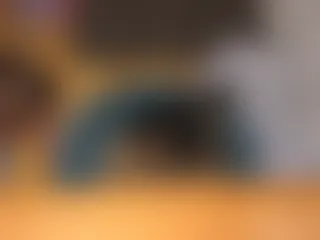
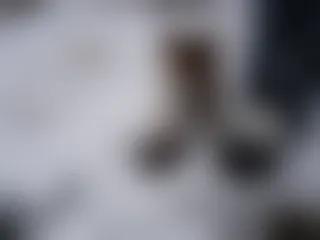
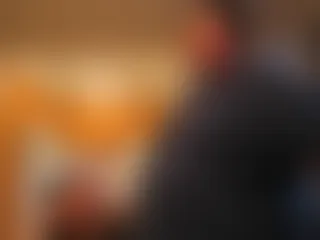
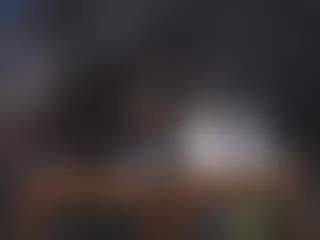
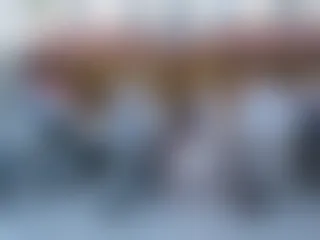
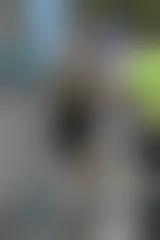
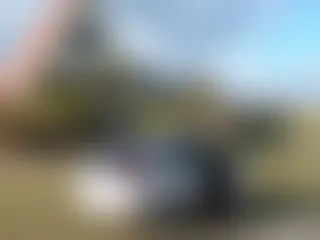
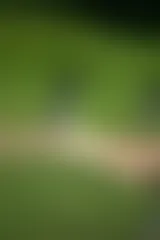
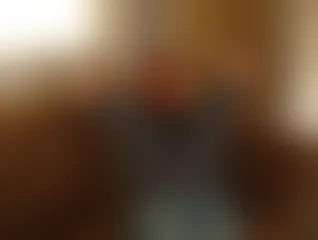
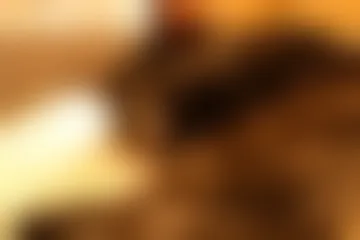
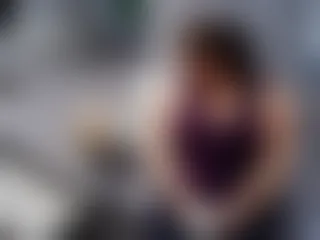
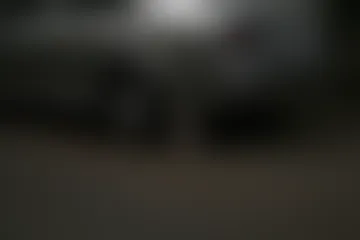
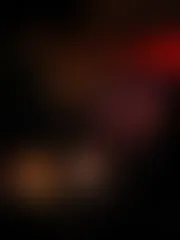
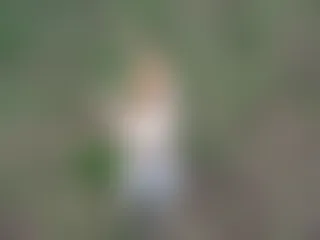
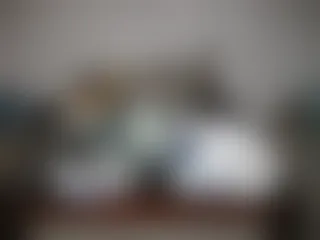
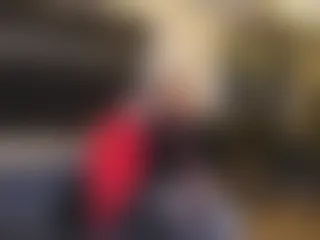
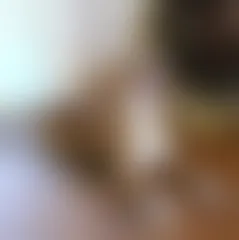
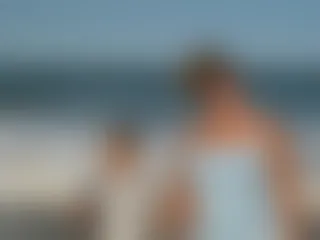
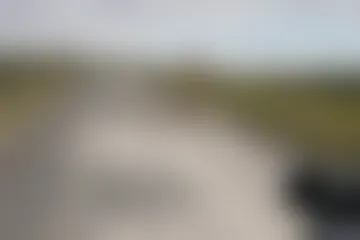
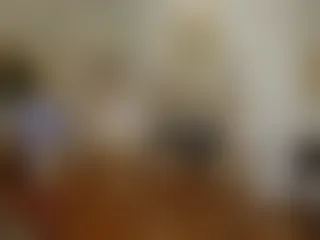
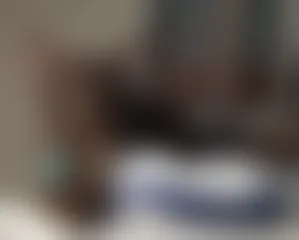
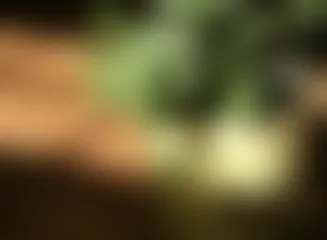
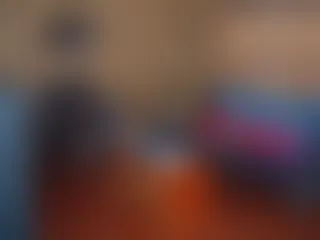
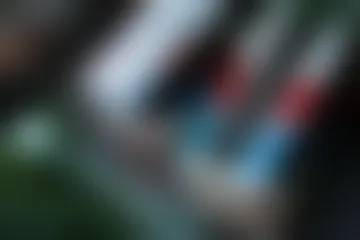
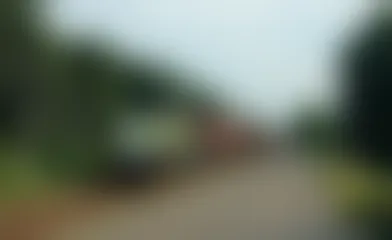
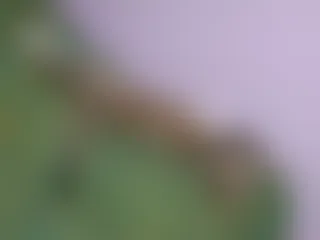
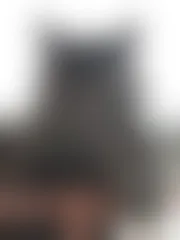
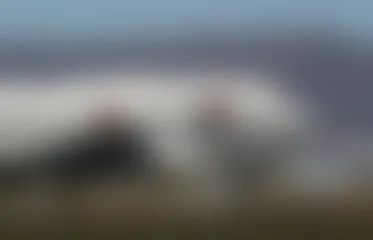
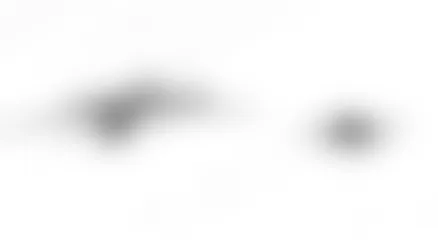
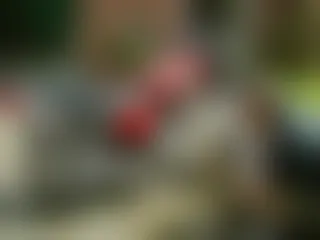
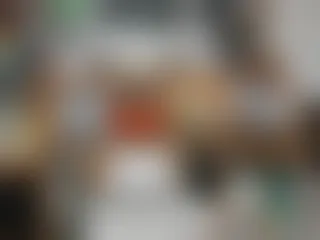
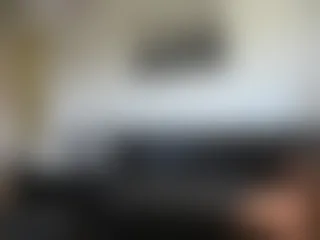
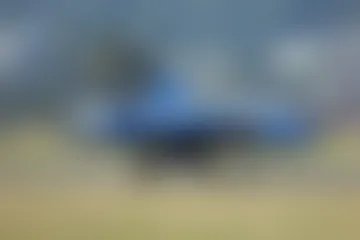
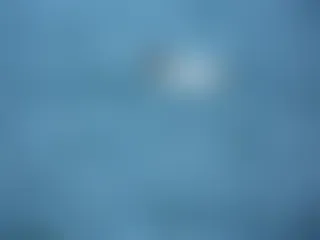
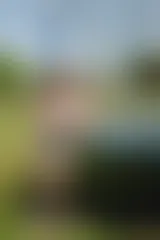
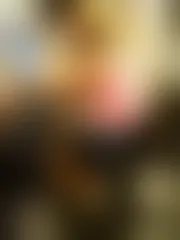
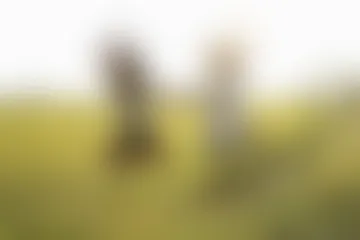
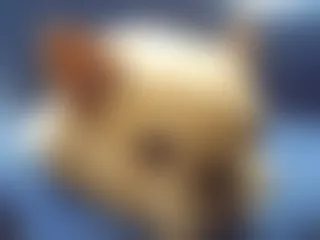
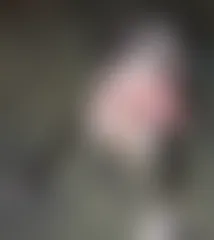
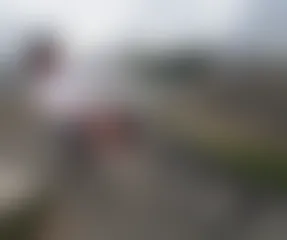
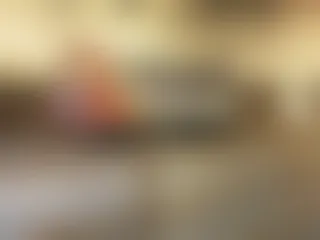
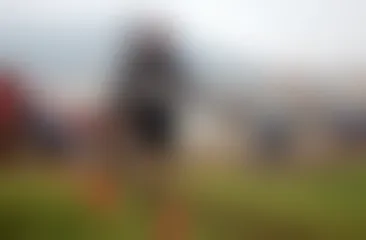
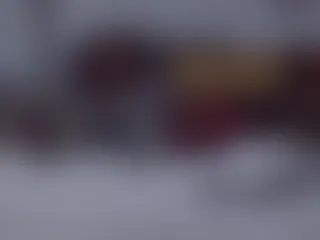
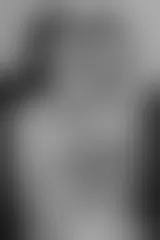
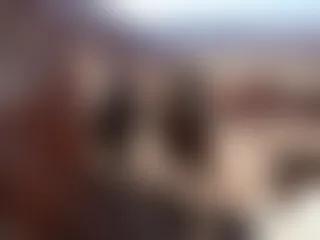
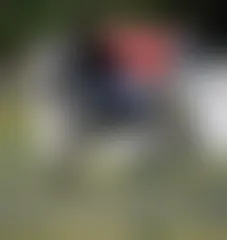

In [83]:
ES.search(index=ES_INDEX, query={"match_all": {}}, size=50)